In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import unittest
import lib
import lib.layers.activation as activation
import lib.layers.core as core
import lib.evaluation as evaluation
import lib.layers.objective as objective
import lib.layers.conv as conv

loader = unittest.TestLoader()
suite = unittest.TestSuite()
runner = unittest.TextTestRunner()

suite.addTests(loader.loadTestsFromModule(lib))
suite.addTests(loader.loadTestsFromModule(activation))
suite.addTests(loader.loadTestsFromModule(core))
suite.addTests(loader.loadTestsFromModule(evaluation))
suite.addTests(loader.loadTestsFromModule(objective))
suite.addTests(loader.loadTestsFromModule(conv))

results = runner.run(suite)

.......................................D:\repos\psa-dataset\lib\layers\objective\logistic.py:11: RuntimeWarning: divide by zero encountered in log
  return -np.log(estimate)
.............
----------------------------------------------------------------------
Ran 52 tests in 0.184s

OK


In [3]:
IMAGE_SHAPE = (600,400)

In [227]:
from lib.io import FileReader
import numpy as np
import itertools
import cv2
import gc

data = np.empty((1, 240001), dtype=float)

for i in itertools.count():
    if i > 1:
        break
        
    file_in = f"data/processed/{i:04}.csv"
    print(file_in)
        
    file_reader = FileReader()
    file_reader.open(file_in)
    
    chunk = []
    try:
        for line in file_reader.read_lines():
            splt = line.split(',')
            chunk.append(splt)
            break
        chunk = np.array(chunk, dtype=float)
        print(chunk.shape)
        data = np.append(data, chunk, axis=0)
    except Exception as err:
        print(err)
        break
    finally:
        file_reader.close()
        gc.collect()
        
data = np.array(data)
data = np.delete(data, 0, axis=0)

data/processed/0000.csv
(1, 240001)
data/processed/0001.csv
(1, 240001)


In [234]:
from PIL import Image
print(data[0].shape)
img = cv2.cvtColor(np.uint8(data[0][1:]).reshape((600,400)), cv2.COLOR_GRAY2RGB)
Image.fromarray(img).save('sample_processed.png')

(240001,)


In [10]:
import numpy as np

np.random.seed(0)
np.random.shuffle(data)

In [11]:
data.shape

(306, 240001)

In [12]:
RATIO = 2/3
N = data.shape[0]
splt = int(N * RATIO)

data_train = data[:splt]
data_test = data[splt:]

In [13]:
X_train = data_train[:, 1:].astype(int)
y_train = data_train[:, :1].astype(float)
print(X_train.shape, y_train.shape)

(204, 240000) (204, 1)


In [14]:
X_test = data_test[:, 1:].astype(int)
y_test = data_test[:, :1].astype(float)
print(X_test.shape, y_test.shape)

(102, 240000) (102, 1)


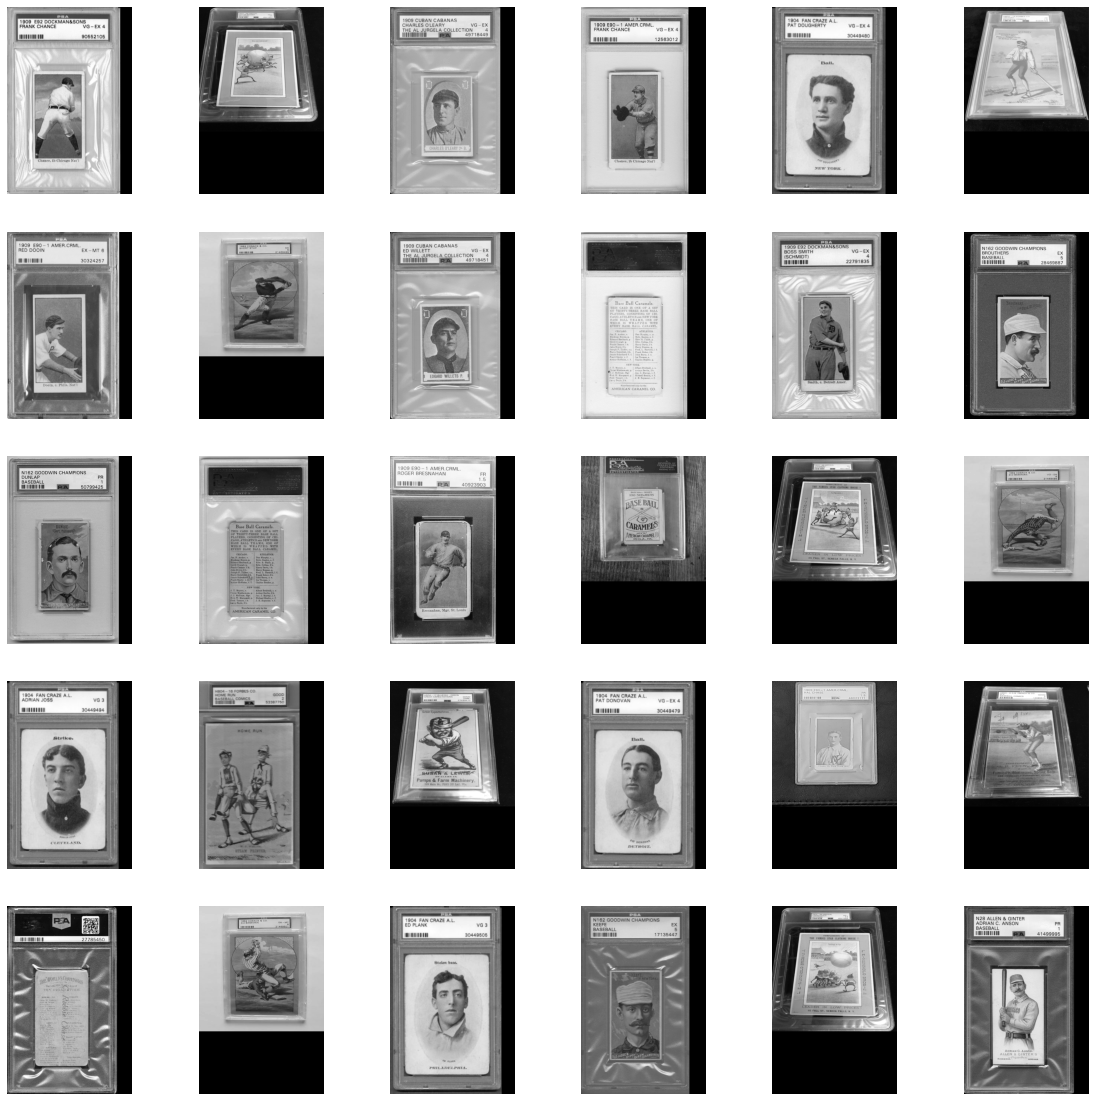

In [77]:
import numpy as np
import matplotlib.pyplot as plt

numb_cols = 6
numb_rows = 5

fix, axs = plt.subplots(numb_rows, numb_cols, figsize=(20,20))

def show(ax, sample, title=None):
    ax.imshow(sample.reshape(IMAGE_SHAPE), cmap='gray')
    ax.axis('off')
    if title:
        ax.set_title(title)
        
i = 0
for j in range(numb_rows):
    for col in range(numb_cols):
        show(axs[j,col], X_train[i])
        i += 1

plt.show()

In [106]:
def normalize(ys, mx=10):
    return mx * (ys-np.min(ys)) / (np.max(ys)-np.min(ys)+1e-9)

In [108]:
def fp(model, xs, do_normalize=True):
    return (normalize(model.eval(xs))
            if do_normalize
            else model.eval(xs))

In [109]:
from lib.evaluation import root_mean_squared_error

def RMSE(model, xs, y_true, do_normalize=True):
    y_pred = fp(model, xs, do_normalize=do_normalize)
    return root_mean_squared_error(y_true, y_pred)

In [241]:
import numpy as np
from lib.layers.core import InputLayer, FullyConnectedLayer
from lib.layers.activation import ReluLayer
from lib.layers.objective import SquaredError
from lib.models import Model

def create_simple_model(config):
    
    np.random.seed(0)
    
    learning_rate = config.get('learning_rate')
    scale = config.get('scale')
    
    layers = [
        InputLayer(X_train),
        
        FullyConnectedLayer(X_train.shape[1], 64, learning_rate=learning_rate, scale=scale),
        ReluLayer(leaky=True),
        
        FullyConnectedLayer(64, 1, learning_rate=learning_rate, scale=scale),
        ReluLayer(leaky=True),
        
        SquaredError(),
    ]
    
    return Model(layers=layers)

In [253]:
config = {
    'learning_rate': 5e-7,
    'scale': 1,
}
model = create_simple_model(config)
losses = []
rmses = []

In [271]:
epochs = 100
for epoch in range(epochs):
    model.train(X_train, y_train, batch_size=10)
    N = X_train.shape[0]
    loss = model.loss(X_train, y_train)
    avg_loss = np.average(loss)
    rmse = RMSE(model, X_test, y_test)
    rmses.append(rmse)
    losses.append(avg_loss)

In [272]:
losses[-10:]

[23.867815337363286,
 23.743896261555737,
 23.646803810709944,
 23.51820866117221,
 23.401023961323773,
 23.279607538344578,
 23.15720559571872,
 23.032427977398342,
 22.911802213324016,
 22.78939882593244]

In [273]:
rmses[-10:]

[2.5328429891392297,
 2.532870185005807,
 2.534437784916748,
 2.5278097590989184,
 2.531137662866749,
 2.527993913847457,
 2.530140697356919,
 2.529076018843859,
 2.5304132786332207,
 2.5302300234741533]

In [274]:
y_pred = fp(model, X_test[:10])
y_true = y_test[:10]

In [275]:
y_pred, y_true

(array([[ 4.45552698],
        [ 1.16683542],
        [ 8.59970436],
        [ 0.69612544],
        [10.        ],
        [ 0.75785245],
        [ 8.91568837],
        [ 7.27998157],
        [ 0.        ],
        [ 2.2633794 ]]),
 array([[3. ],
        [3. ],
        [2. ],
        [3. ],
        [4. ],
        [4.5],
        [4. ],
        [4. ],
        [1. ],
        [3.5]]))

In [319]:
import numpy as np
from lib.layers.core import InputLayer, FullyConnectedLayer
from lib.layers.activation import ReluLayer
from lib.layers.objective import SquaredError
from lib.layers.conv import ConvolutionalLayer, FlattenLayer, UnflattenLayer, PoolingLayer
from lib.models import Model

def create_conv_model(config):
    
    np.random.seed(0)
    
    learning_rate = config.get('learning_rate')
    scale = config.get('scale')
    stride = config.get('stride')
    
    layers = [
        UnflattenLayer(IMAGE_SHAPE)
    ]
    
    conv = ConvolutionalLayer(IMAGE_SHAPE, 3, learning_rate=learning_rate)
    layers.append(conv)
    shape = conv.out_shape()
    
    conv = ConvolutionalLayer(shape, 3, learning_rate=learning_rate)
    layers.append(conv)
    shape = conv.out_shape()
    
    conv = ConvolutionalLayer(shape, 3, learning_rate=learning_rate)
    layers.append(conv)
    shape = conv.out_shape()

    conv = ConvolutionalLayer(shape, 3, learning_rate=learning_rate)
    layers.append(conv)
    shape = conv.out_shape()
    
    print(shape)
    
    pool = PoolingLayer(shape, 4, stride=stride)
    layers.append(pool)
    shape = pool.out_shape()
    
    flatten = FlattenLayer()
    layers.append(flatten)
    
    layers.extend([
        FullyConnectedLayer(shape[0] * shape[1], 1, learning_rate=learning_rate, scale=scale),
        ReluLayer(leaky=True),
        
        SquaredError(),
    ])
    
    return Model(layers=layers)

In [320]:
config = {
    'learning_rate': 1e-3,
    'scale': 1e-2,
    'stride': 3
}
model = create_conv_model(config)
conv_losses = []
conv_rmses = []

(592, 392)


In [ ]:
epochs = 3

np.random.seed(0)

N = X_train.shape[0]

X_samples = X_train[:5]
y_samples = y_train[:5]

for epoch in range(epochs):
    
    idx = np.random.randint(0, N)
    X_sample = X_train[idx]
    y_sample = y_train[idx]
    
    print('Epoch:', len(conv_losses))
    model.train(X_sample, y_sample)
    
    loss = [model.loss(x, y) for x, y in zip(X_samples, y_samples)]
    avg_loss = np.average(loss)
    
    y_pred = [model.eval(x) for x in X_samples]
    y_true = y_samples

    rmse = root_mean_squared_error(y_true, y_pred)
    conv_rmses.append(rmse)
    conv_losses.append(avg_loss)

Epoch: 0


In [ ]:
import matplotlib.pyplot as plt

N = len(conv_losses)

epochs = [i for i in range(N)]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(epochs, losses[:N], label="MLP", color='blue')
ax2.plot(epochs, conv_losses, label="Convolutional", color='orange')

ax1.set_ylabel("$J_{mlp}$")
ax1.set_xlabel("Epoch")

ax2.set_ylabel("$J_{conv}$")

plt.title("Loss")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

plt.legend(lines, labels, loc=0)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

N = len(conv_losses)

epochs = [i for i in range(N)]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(epochs, rmses[:N], label="MLP", color='blue')
ax2.plot(epochs, conv_rmses, label="Convolutional", color='orange')

ax1.set_ylabel("$RMSE_{mlp}$")
ax1.set_xlabel("Epoch")

ax2.set_ylabel("$RMSE_{conv}$")

plt.title("RMSE")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

plt.legend(lines, labels, loc=0)
plt.show()